In [ ]:
import numpy as np
import pandas as pd
import math
import datetime

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from plotly.offline import init_notebook_mode, iplot, plot
import plotly.express as px
import plotly as py
init_notebook_mode(connected=True)
import plotly.graph_objs as go

from warnings import simplefilter
simplefilter("ignore")

from tqdm.notebook import tqdm_notebook

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(12, 6),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

import random
import os

SEED = 2021
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(SEED)

pd.set_option('display.max_columns', None)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LarsCV
from sklearn.linear_model import BayesianRidge
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.neighbors import NearestCentroid

from sklearn.linear_model import QuantileRegressor
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Perceptron
from sklearn.linear_model import HuberRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor

from sklearn.multioutput import RegressorChain
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error

#  My other notebooks :
* [Basic EDA with visualization  and animated polar plot](https://www.kaggle.com/code/martynovandrey/tps-mar-22-step-0-data-exploration-animation) 
* [Looking for special values, EDA](https://www.kaggle.com/code/martynovandrey/tps-mar-22-step-0-1-special-values)
* [Features selection](https://www.kaggle.com/code/martynovandrey/tps-mar-22-fe-the-less-the-better)
* [MultiOutput regressor, 65 targets in one](https://www.kaggle.com/code/martynovandrey/tps-mar-22-multioutput-regressor)
* [Hybrid regressor, two step model](https://www.kaggle.com/code/martynovandrey/tps-mar-22-hybrid-regressors)
* [Multimodel regression, blendig, postprocessing - my best public score so far](https://www.kaggle.com/code/martynovandrey/tps-mar-22-fe-model-selection)
* [How to use special values to improve submission, dataset shared](https://www.kaggle.com/code/martynovandrey/tps-mar-22-don-t-forget-special-values)

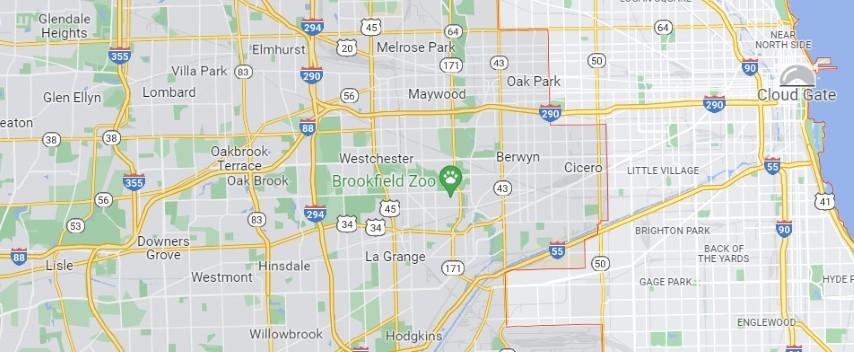

# Foreword
### MultiOutput
* In [TPS Mar 22, Step 0 - Data Exploration, animation](https://www.kaggle.com/martynovandrey/tps-mar-22-step-0-data-exploration-animation) notebook I used polar plots to show congestions for all location (x&y) direction, like this  
  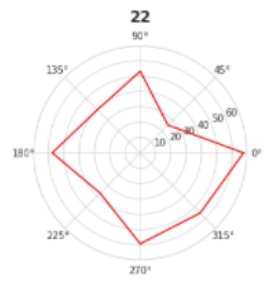  
and animation to see how congestions change by time.  
* In [TPS Mar 22 MultiOutput, Compare Models](https://www.kaggle.com/martynovandrey/tps-mar-22-multioutput-compare-models) I tried to use congestions of eight possible direction as one target and model with **MultiOutputRegressor**.
* This time I combine congestions of all 65 roadways (x, y, direction) as one target and use **MultiOutputRegressor** and **ChainRegressor**.

### Special values
* Submission corrected using special values, see details in [TPS Mar 22, Step 0.1, Special values](https://www.kaggle.com/martynovandrey/tps-mar-22-step-0-1-special-values)

In [ ]:
df_train = pd.read_csv('../input/tabular-playground-series-mar-2022/train.csv', index_col="row_id", parse_dates=['time'])
df_test = pd.read_csv('../input/tabular-playground-series-mar-2022/test.csv', index_col="row_id", parse_dates=['time'])

### Date and time features

In [ ]:
def add_datetime_features(df):
    df['month']   = df['time'].dt.month
    df['day']     = df['time'].dt.day
    df['weekday'] = df['time'].dt.weekday
    df['weekend'] = (df['time'].dt.weekday >= 5)   
    df['hour']    = df['time'].dt.hour
    df['minute']  = df['time'].dt.minute
    df['afternoon'] = df['hour'] >= 12
    
    # number of 20' period in a day
    df['moment']  = df['time'].dt.hour * 3 + df['time'].dt.minute // 20 
    
add_datetime_features(df_train)
add_datetime_features(df_test)    

### x, y, direction -> "road"

In [ ]:
df_train['road'] = df_train['x'].astype(str) + df_train['y'].astype(str) + df_train['direction']
df_test['road']  = df_test['x'].astype(str) + df_test['y'].astype(str) + df_test['direction']

le = LabelEncoder()
df_train['road'] = le.fit_transform(df_train['road'])
df_test['road']  = le.transform(df_test['road'])

df_train = df_train.drop(['x', 'y', 'direction'], axis=1)
df_test = df_test.drop(['x', 'y', 'direction'], axis=1)

* We will use all 65 roadway congestions as one target, let's see all at once in dynamic on one animated plot.

In [ ]:
sample = df_train[df_train.month >= 9]
sample['roadway'] = le.inverse_transform(sample['road'])
te = LabelEncoder()
sample['tic'] = te.fit_transform(sample['time'])
sample = sample[['tic', 'congestion', 'roadway']]
fig = px.line_polar(sample, 
              r='congestion',
              range_r = [0, 100],
              theta="roadway", 
              height= 700,
              markers=True,
              line_close=True,
              title = '65 roadway congestions by "tic" (unique time number)',
              animation_frame="tic")
fig.update_layout(font_size=8)
fig.show()

### median, min, max, morning average congestion features

In [ ]:
medians = pd.DataFrame(df_train.groupby(['road', 'weekday', 'hour', 'minute']).congestion.median().astype(int)).reset_index()
medians = medians.rename(columns={'congestion':'median'})
df_train = df_train.merge(medians, on=['road', 'weekday', 'hour', 'minute'], how='left')
df_test = df_test.merge(medians, on=['road', 'weekday', 'hour', 'minute'], how='left')

mins = pd.DataFrame(df_train.groupby(['road', 'weekday', 'hour', 'minute']).congestion.min().astype(int)).reset_index()
mins = mins.rename(columns={'congestion':'min'})
df_train = df_train.merge(mins, on=['road', 'weekday', 'hour', 'minute'], how='left')
df_test = df_test.merge(mins, on=['road', 'weekday', 'hour', 'minute'], how='left')

maxs = pd.DataFrame(df_train.groupby(['road', 'weekday', 'hour', 'minute']).congestion.max().astype(int)).reset_index()
maxs = maxs.rename(columns={'congestion':'max'})
df_train = df_train.merge(maxs, on=['road', 'weekday', 'hour', 'minute'], how='left')
df_test = df_test.merge(maxs, on=['road', 'weekday', 'hour', 'minute'], how='left')

df_mornings = df_train[(df_train.hour >= 6) & (df_train.hour < 12)]
morning_avgs = pd.DataFrame(df_mornings.groupby(['month', 'day', 'road']).congestion.median().astype(int)).reset_index()
morning_avgs = morning_avgs.rename(columns={'congestion':'morning_avg'})
df_train = df_train.merge(morning_avgs, on=['month', 'day', 'road'], how='left')
df_test = df_test.merge(morning_avgs, on=['month', 'day', 'road'], how='left')

# Drop unimportant features
* Feature selection is in the [TPS Mar 22, FE, the less the better](https://www.kaggle.com/martynovandrey/tps-mar-22-fe-the-less-the-better) notebook. I used mutual information, permutation importances and SHAP to find features to remove, the score improved by 0.023

In [ ]:
df_train = df_train.drop(['month', 'day', 'weekday', 'weekend', 'hour', 'minute', 'afternoon'], axis=1)
df_test = df_test.drop(['month', 'day', 'weekday', 'weekend', 'hour', 'minute', 'afternoon'], axis=1)

# 65 congestion values -> "target"

In [ ]:
roads = df_train['road'].unique().tolist()

train = df_train[['time', 'moment']].reset_index(drop=True).drop_duplicates().reset_index(drop=True)
test  = df_test[['time', 'moment']].reset_index(drop=True).drop_duplicates().reset_index(drop=True)

tmp = df_train[['time', 'road', 'congestion']]
tmp = pd.pivot(tmp, index=['time'], columns='road', values='congestion')
tmp['target'] = tmp[roads].values.tolist()
tmp = tmp.drop(roads, axis=1)
train = train.merge(tmp, on='time', how='left')

for feature in ['median', 'min', 'max', 'morning_avg']:
    tmp = df_train[['time', 'road', feature]]
    tmp = pd.pivot(tmp, index=['time'], columns='road', values=feature)
    for road in roads:
        tmp = tmp.rename(columns={road:f'{feature[:3]}_{road}'})
    train = train.merge(tmp, on='time', how='left')
    
    tmp = df_test[['time', 'road', feature]]
    tmp = pd.pivot(tmp, index=['time'], columns='road', values=feature)
    for road in roads:
        tmp = tmp.rename(columns={road:f'{feature[:3]}_{road}'})
    test = test.merge(tmp, on='time', how='left')

### split train -> valid_train, valid_test

In [ ]:
tst_start = pd.to_datetime('1991-09-23 12:00')
tst_finish = pd.to_datetime('1991-09-23 23:40')

valid_test = train[(train['time'] >= tst_start) & (train['time'] <= tst_finish)].drop(['target'], axis=1)
valid_train = train[train['time'] < tst_start]

tmp = df_train[(df_train['time'] >= tst_start) & (df_train['time'] <= tst_finish)]
valid_target = tmp.pop('congestion')
valid_sample_submission = tmp.copy()
valid_sample_submission['congestion'] = 50
valid_sample_submission = valid_sample_submission['congestion'] 

X_train = valid_train.copy()
X_train = X_train.drop(['time'], axis=1)
Y_train = np.array(list(X_train['target']))
X_train = X_train.drop(['target'], axis=1)

X_test = valid_test.drop(['time'], axis=1)

In [ ]:
def reverse(df):
    tmp = []
    for ind in df.index:
        for road in roads:
            sample = {}
            sample['time'] = df['time'][ind]
            sample['road'] = road
            sample['congestion'] = df[road][ind]
            tmp.append(sample)
    return pd.DataFrame(tmp)

### MedianRegressor

In [ ]:
class MedianRegressor:
    def __init__(self):
        self.medians = None
        
    def fit(self, X, y):
        df = X.copy()
        df['target'] = y
        self.medians = df.groupby(['moment']).target.median()
        self.medians = self.medians - 0.00001
        self.medians = self.medians.round().astype(int)

    def predict(self, X):
        sub = X.merge(self.medians, left_on=['moment'], right_index=True)[['target']]
        return sub['target']
    
    def get_params(self, deep=True):
        return dict()

### Function to compare regressors

In [ ]:
def compare_or_sub(regressors, X_train, Y_train, X_test, sample_submission, valid_target=[]):
    subs = pd.DataFrame()
    for rgr in regressors:
        print(rgr['name'].ljust(10), end=' ')
        
        if rgr['mode'] == 'multi':
            model = MultiOutputRegressor(rgr['model'])
        else:
            model = RegressorChain(base_estimator=rgr['model'])
            
        model.fit(X_train, Y_train)
        Y_predict = model.predict(X_test)
        
        pred = pd.DataFrame(Y_predict)
        pred.columns = roads
        pred = pd.concat([test[['time']], pred], axis=1)
        
        prediction = reverse(pred)
        prediction['road'] = le.inverse_transform(prediction['road'])
        
        sub = pd.DataFrame(sample_submission)
        prediction.index = sub.index
        sub['congestion'] = prediction['congestion']
        subs = pd.concat([subs, sub.rename(columns={'congestion':rgr['name']})], axis=1)
        
        if len(valid_target) > 0:
            sub['congestion'] = sub['congestion'].apply(lambda x: round(x))
            sub_target = sub['congestion']
            mae = mean_absolute_error(valid_target, sub_target)
            rgr['score'] = mae
            print(rgr['description'].rjust(30), f'test = {mae:.3f}\n')
        
    subs['congestion'] = subs.mean(axis=1).apply(lambda x: round(x))
    df_regressors = pd.DataFrame(regressors)

    if len(valid_target) > 0:
        sub_target = subs['congestion']
        mae = mean_absolute_error(valid_target, sub_target)
        print('BLENDED'.rjust(30), f'test = {mae:.3f}\n')
        fig, ax = plt.subplots(figsize=(16, 5))
        sns.barplot(data=df_regressors, x='name', y='score', ax=ax)
        ax.set_ylim(bottom=4.8)
    
    return df_regressors, subs

* SKLearn has two multioutput regression tools, **[MultiOutputRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputRegressor.html#sklearn.multioutput.MultiOutputRegressor)** and **[RegressorChain](https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.RegressorChain.html#sklearn.multioutput.RegressorChain)**, I'm to try and compare both.

In [ ]:
# Select regressors to compare
regressors = []
regressors.append({'name': 'MDR_m',  'mode':'multi', 'model': MedianRegressor(), 'description': 'MedianRegressor'})
# regressors.append({'name': 'LIN_m',  'mode':'multi', 'model': LinearRegression(), 'description': 'LinearRegressor'})
# regressors.append({'name': 'LIN_c',  'mode':'chain', 'model': LinearRegression(), 'description': 'LinearRegressor'})
# regressors.append({'name': 'HUB_m',  'mode':'multi', 'model': HuberRegressor(), 'description': 'HuberRegressor'})
# regressors.append({'name': 'HUB_c',  'mode':'chain', 'model': HuberRegressor(), 'description': 'HuberRegressor'})

regressors.append({'name': 'LGBM_m30', 'mode':'multi', 'model': LGBMRegressor(n_estimators=30, metric='mae'), 'description': 'LGBMRegressor'})
regressors.append({'name': 'LGBM_c70', 'mode':'chain', 'model': LGBMRegressor(n_estimators=70, metric='mae'), 'description': 'LGBMRegressor'})
regressors.append({'name': 'CAT_m',  'mode':'multi', 'model': CatBoostRegressor(n_estimators=200, logging_level='Silent', eval_metric='MAE', loss_function='MAE'),  'description': 'CatBoostRegressor'})
regressors.append({'name': 'CAT_c170',  'mode':'chain', 'model': CatBoostRegressor(n_estimators=170,logging_level='Silent', eval_metric='MAE', loss_function='MAE'),  'description': 'CatBoostRegressor'})
regressors.append({'name': 'HGBR_c100', 'mode':'chain', 'model': HistGradientBoostingRegressor(max_iter=100,loss='absolute_error'), 'description': 'HistGradientBoostingRegressor'})
regressors.append({'name': 'HGBR_m500', 'mode':'multi', 'model': HistGradientBoostingRegressor(max_iter=500,loss='absolute_error'), 'description': 'HistGradientBoostingRegressor'})

df, subs = compare_or_sub(regressors, X_train, Y_train, X_test, valid_sample_submission, valid_target)

# SUBMITION

In [ ]:
# Select regressors to compare
regressors = []
regressors.append({'name': 'MDR_m',  'mode':'multi', 'model': MedianRegressor(), 'description': 'MedianRegressor'})
# regressors.append({'name': 'LIN_m',  'mode':'multi', 'model': LinearRegression(), 'description': 'LinearRegressor'})
# regressors.append({'name': 'LIN_c',  'mode':'chain', 'model': LinearRegression(), 'description': 'LinearRegressor'})
# regressors.append({'name': 'HUB_m',  'mode':'multi', 'model': HuberRegressor(), 'description': 'HuberRegressor'})
# regressors.append({'name': 'HUB_c',  'mode':'chain', 'model': HuberRegressor(), 'description': 'HuberRegressor'})

regressors.append({'name': 'LGBM_m30', 'mode':'multi', 'model': LGBMRegressor(n_estimators=30, metric='mae'), 'description': 'LGBMRegressor'})
regressors.append({'name': 'LGBM_c70', 'mode':'chain', 'model': LGBMRegressor(n_estimators=70, metric='mae'), 'description': 'LGBMRegressor'})
regressors.append({'name': 'CAT_m',  'mode':'multi', 'model': CatBoostRegressor(n_estimators=200, logging_level='Silent', eval_metric='MAE', loss_function='MAE'),  'description': 'CatBoostRegressor'})
regressors.append({'name': 'CAT_c170',  'mode':'chain', 'model': CatBoostRegressor(n_estimators=170,logging_level='Silent', eval_metric='MAE', loss_function='MAE'),  'description': 'CatBoostRegressor'})
regressors.append({'name': 'HGBR_c100', 'mode':'chain', 'model': HistGradientBoostingRegressor(max_iter=100,loss='absolute_error'), 'description': 'HistGradientBoostingRegressor'})
regressors.append({'name': 'HGBR_m500', 'mode':'multi', 'model': HistGradientBoostingRegressor(max_iter=500,loss='absolute_error'), 'description': 'HistGradientBoostingRegressor'})

In [ ]:
X_train = train.copy()
X_train = X_train.drop(['time'], axis=1)
Y_train = np.array(list(X_train['target']))
X_train = X_train.drop(['target'], axis=1)
X_test = test.drop(['time'], axis=1)

In [ ]:
sample_submission = pd.read_csv('../input/tabular-playground-series-mar-2022/sample_submission.csv', index_col="row_id")

### Predictions

In [ ]:
df_regressors_sub, subs = compare_or_sub(regressors, X_train, Y_train, X_test, sample_submission)
subs

### special values

In [ ]:
special = pd.read_csv('../input/tps-mar-22-special-values/special v2.csv', index_col="row_id")
special = special[['congestion']].rename(columns={'congestion':'special'})

In [ ]:
subs.index = sample_submission.index

for rgr in regressors:
    sub = sample_submission.copy()
    sub['congestion'] = subs[rgr['name']]
    sub = sub.merge(special, left_index=True, right_index=True, how='left')
    sub['special'] = sub['special'].fillna(sub['congestion']).round().astype(int)
    sub = sub.drop(['congestion'], axis=1).rename(columns={'special':'congestion'})
    sub.to_csv(f"submission {rgr['name']} spec rounded.csv", index=True)

In [ ]:
subs.index = sample_submission.index
sub = sample_submission.copy()
sub['congestion'] = subs['congestion']
sub = sub.merge(special, left_index=True, right_index=True, how='left')
sub['special'] = sub['special'].fillna(sub['congestion']).round().astype(int)
sub = sub.drop(['congestion'], axis=1).rename(columns={'special':'congestion'})
sub.to_csv('submission blend spec rounded.csv', index=True)

In [ ]:
train = pd.read_csv('../input/tabular-playground-series-mar-2022/train.csv', parse_dates=['time'])
train['hour'] = train['time'].dt.hour
train['minute'] = train['time'].dt.minute

submission_in = sub.copy()
# Compute the quantiles of workday afternoons in September except Labor Day
sep = train[(train.time.dt.hour >= 12) & (train.time.dt.weekday < 5) &
            (train.time.dt.dayofyear >= 246)]
lower = sep.groupby(['hour', 'minute', 'x', 'y', 'direction']).congestion.quantile(0.2).values
upper = sep.groupby(['hour', 'minute', 'x', 'y', 'direction']).congestion.quantile(0.7).values

# Clip the submission data to the quantiles
submission_out = submission_in.copy()
submission_out['congestion'] = submission_in.congestion.clip(lower, upper)

# Display some statistics
mae = mean_absolute_error(submission_in.congestion, submission_out.congestion)
print(f'Mean absolute modification: {mae:.4f}')
print(f"Submission was below lower bound: {(submission_in.congestion <= lower - 0.5).sum()}")
print(f"Submission was above upper bound: {(submission_in.congestion > upper + 0.5).sum()}")

# Round the submission
submission_out['congestion'] = submission_out.congestion.round().astype(int)
submission_out.to_csv('submission_blend_corrected_rounded.csv')
submission_out